# Zadanie domowe 4
Agata Kaczmarek

Ten dokument zawiera zadanie dotyczące SVM. Będę pracować na dwóch zbiorach danych *apartments* oraz *diabetes*. Na początku dopasuję algorytm SVM do obu zbioru danych. Następnie zajmę się kwestią skalowania danych zawartych w zbiorach. Na koniec tej części spróbuję zopytmalizować najważniejsze hiperparametry. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
np.random.seed = 42

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_auc_score
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

### Zbiór *apartments*

Naszą zmienną celu jest zmienna ceny, czyli nasz problem jest problemem regresji. Przyjrzyjmy się na początek naszym danym.

In [24]:
apartments_df = pd.read_csv('apartments.csv')
apartments_df = apartments_df.drop(apartments_df.columns[0], axis=1)
apartments_df.head()


,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,Srodmiescie
1,1818,1992,143,9,5,Bielany
2,3643,1937,56,1,2,Praga
3,3517,1995,93,7,3,Ochota
4,3013,1992,144,6,5,Mokotow


In [25]:
apartments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2.price           1000 non-null   int64 
 1   construction.year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no.rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 43.0+ KB


Nie ma żadnych braków danych, tylko kolumna *district* jest nienumeryczna, jak widzimy poniżej, zawiera 10 różnych wartości.

In [11]:
apartments_df.district.nunique()

10

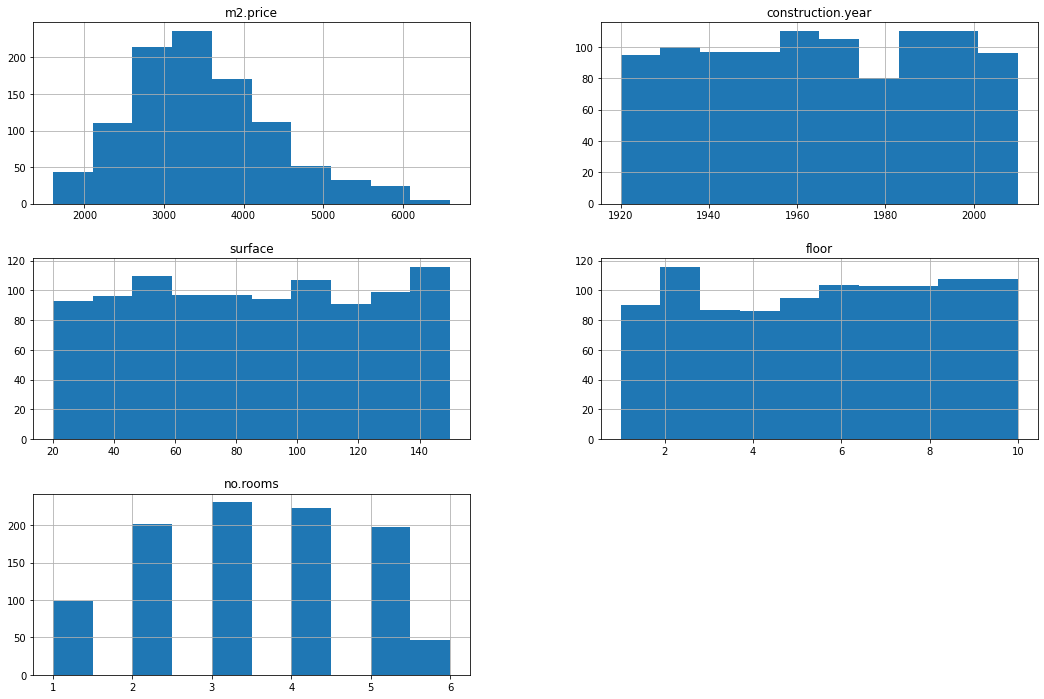

In [22]:
apartments_df.hist(bins=10, figsize=(18,12))
plt.show()

### Zbiór diabetes

Naszą zmienną celu jest class, chcemy się dowiedzieć, czy dana osoba wykazuje symptomy cukrzycy zgodnie z kryteriami WHO.

In [26]:
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [27]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 51.1+ KB


In [28]:
diabetes_df["class"].value_counts()

tested_negative    500
tested_positive    268
Name: class, dtype: int64

Jak widzimy, w tym zbiorze również nie ma problemu z brakami danych. Około 1/3 zbioru dostała pozytywny wynik, pozostałe 2/3 negatywny - podczas podziału tego zbioru na zbiór treningowy i testowy wezmę to pod uwagę.

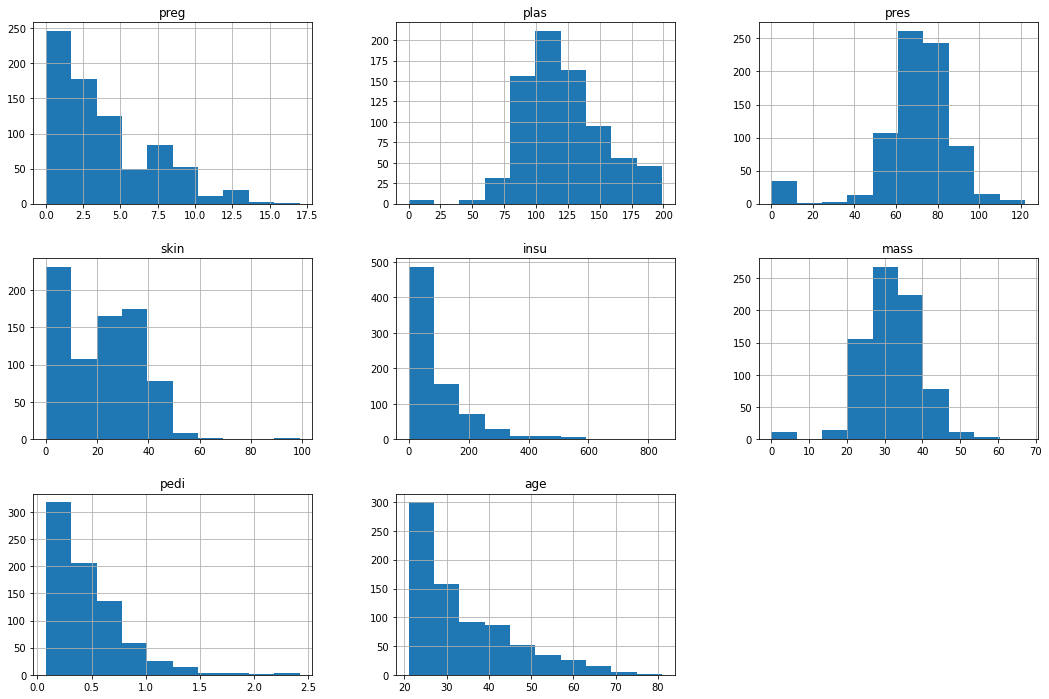

In [23]:
diabetes_df.hist(bins=10, figsize=(18,12))
plt.show()

### Przygotowanie zbioru treningowego i testowego

#### Apartments

In [29]:
y_true_a=np.array(apartments_df["m2.price"])
x_true_a=apartments_df.drop(["m2.price"],axis=1)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(x_true_a,y_true_a,test_size=0.3,random_state=42)
print(X_train_a.shape[0], X_test_a.shape[0], y_train_a.shape[0], y_test_a.shape[0])

700 300 700 300


#### Diabetes

In [30]:
def class_name(class_name):
  return{
      "tested_negative":0,
      "tested_positive":1
  }[class_name]
diabetes_df["class"]=diabetes_df["class"].apply(class_name)
diabetes_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [31]:
y_true_d=np.array(diabetes_df["class"])
x_true_d=diabetes_df.drop(["class"],axis=1)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x_true_d, y_true_d,test_size=0.3,random_state=42, stratify=y_true_d)
print(X_train_d.shape[0], X_test_d.shape[0], y_train_d.shape[0], y_test_d.shape[0])

537 231 537 231


### SVM

#### Apartments

In [32]:
# bez skalowania
pipe_1_a=Pipeline([
    ('encoder', TargetEncoder(cols=["district"])),
    ('model', SVR())
])
pipe_1_a.fit(X_train_a, y_train_a)
y_test_hat_a=pipe_1_a.predict(X_test_a)
y_train_hat_a=pipe_1_a.predict(X_train_a)

print(f'RMSE dla treningowych: {np.sqrt(mean_squared_error(y_train_a, y_train_hat_a)):.3f}')
print(f'RMSE dla testowych: {np.sqrt(mean_squared_error(y_test_a, y_test_hat_a)):.3f}')

RMSE dla treningowych: 889.922
RMSE dla testowych: 898.494


In [33]:
# ze skalowaniem
pipe_2_a=Pipeline([
    ('encoder', TargetEncoder(cols=["district"])),
    ('scaler', StandardScaler()),
    ('model', SVR())
])
pipe_2_a.fit(X_train_a, y_train_a)
y_test_hat_a=pipe_2_a.predict(X_test_a)
y_train_hat_a=pipe_2_a.predict(X_train_a)

print(f'RMSE dla treningowych: {np.sqrt(mean_squared_error(y_train_a, y_train_hat_a)):.3f}')
print(f'RMSE dla testowych: {np.sqrt(mean_squared_error(y_test_a, y_test_hat_a)):.3f}')

RMSE dla treningowych: 870.310
RMSE dla testowych: 883.271


Dla zbioru apartments skalowanie zmniejszyło błąd, zarówno na zbiorze treningowym jak i na testowym. 

#### Strojenie

In [34]:
apartments_copy=apartments_df.copy()
encoder = TargetEncoder()
apartments_copy["district"] = encoder.fit_transform(apartments_copy["district"], apartments_copy["m2.price"])
apartments_copy.head()

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,5182.750000
1,1818,1992,143,9,5,2985.739583
2,3643,1937,56,1,2,2994.804348
3,3517,1995,93,7,3,3956.291667
4,3013,1992,144,6,5,3855.457944


In [35]:
y_true_a2=np.array(apartments_copy["m2.price"])
x_true_a2=apartments_copy.drop(["m2.price"],axis=1)
X_train_a2, X_test_a2, y_train_a2, y_test_a2 = train_test_split(x_true_a2,y_true_a2,test_size=0.3,random_state=42)

parameters_svr = {
    'C': [1, 3, 5],
    'gamma': ['auto', 'scale'],
    'degree': [2,3, 6]
}

clf_rand = RandomizedSearchCV(SVR(), param_distributions= parameters_svr, cv=3, n_iter=5)

clf_rand.fit(X_train_a2, y_train_a2)

RandomizedSearchCV(cv=3, estimator=SVR(), n_iter=5,
                   param_distributions={'C': [1, 3, 5], 'degree': [2, 3, 6],
                                        'gamma': ['auto', 'scale']})

In [36]:
pd.DataFrame(clf_rand.cv_results_)[['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False).iloc[0]

params             {'gamma': 'scale', 'degree': 2, 'C': 5}
mean_test_score                                   0.110652
Name: 3, dtype: object

In [37]:
# ze strojeniem
pipe_3_a=Pipeline([
    ('encoder', TargetEncoder(cols=["district"])),
    ('scaler', StandardScaler()),
    ('model', SVR(gamma='scale', degree=3, C=3))
])
pipe_3_a.fit(X_train_a, y_train_a)
y_test_hat_a=pipe_3_a.predict(X_test_a)
y_train_hat_a=pipe_3_a.predict(X_train_a)

print(f'RMSE dla treningowych: {np.sqrt(mean_squared_error(y_train_a, y_train_hat_a)):.3f}')
print(f'RMSE dla testowych: {np.sqrt(mean_squared_error(y_test_a, y_test_hat_a)):.3f}')

RMSE dla treningowych: 800.083
RMSE dla testowych: 814.641


Jak widać wyniki znacznie się poprawiły, co ciekawe degree oraz gamma zostaly defaultowe, tylko trzeci parametr jest inny.

#### Diabetes


In [49]:
# bez skalowania
pipe_1_d=Pipeline([
    ('model', SVC())
])
pipe_1_d.fit(X_train_d, y_train_d)
y_test_hat_d=pipe_1_d.predict(X_test_d)
y_train_hat_d=pipe_1_d.predict(X_train_d)

In [50]:
f1 = f1_score(y_test_d, y_test_hat_d)
print(f'F1 score:' + str(f1))
accuracy = accuracy_score(y_test_d, y_test_hat_d)
print(f'Accuracy:'+ str(accuracy))
auc = roc_auc_score(y_test_d, y_test_hat_d)
print(f'Auc:'+ str(auc))

F1 score:0.5496183206106869
Accuracy:0.7445887445887446
Auc:0.6755555555555555


In [51]:
# ze skalowaniem
pipe_2_d=Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
])
pipe_2_d.fit(X_train_d, y_train_d)
y_test_hat_d=pipe_2_d.predict(X_test_d)
y_train_hat_d=pipe_2_d.predict(X_train_d)


In [52]:
f1 = f1_score(y_test_d, y_test_hat_d)
print(f'F1 score:' + str(f1))
accuracy = accuracy_score(y_test_d, y_test_hat_d)
print(f'Accuracy:'+ str(accuracy))
auc = roc_auc_score(y_test_d, y_test_hat_d)
print(f'Auc:'+ str(auc))

F1 score:0.6068965517241379
Accuracy:0.7532467532467533
Auc:0.7049382716049383


Dla zbiory diabetes skalowanie zmniejszyło błąd, jednak dla danych testowych błąd zmniejszył się znacznie bardziej niż dla danych testowych.

In [53]:
# strojenie

parameters_svr = {
    'C': [1, 3, 5],
    'gamma': ['auto', 'scale'],
    'degree': [2,3, 6]
}

clf_rand_d = RandomizedSearchCV(SVC(), param_distributions= parameters_svr, cv=3, n_iter=5)

clf_rand_d.fit(X_train_d, y_train_d)

RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=5,
                   param_distributions={'C': [1, 3, 5], 'degree': [2, 3, 6],
                                        'gamma': ['auto', 'scale']})

In [54]:
pd.DataFrame(clf_rand_d.cv_results_)[['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False).iloc[0]

params             {'gamma': 'scale', 'degree': 3, 'C': 5}
mean_test_score                                   0.763501
Name: 0, dtype: object

In [55]:
# ze strojeniem 

pipe_3_d=Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(gamma='scale', degree=6, C=5))
])
pipe_3_d.fit(X_train_d, y_train_d)
y_test_hat_d=pipe_3_d.predict(X_test_d)
y_train_hat_d=pipe_3_d.predict(X_train_d)

In [56]:
f1 = f1_score(y_test_d, y_test_hat_d)
print(f'F1 score:' + str(f1))
accuracy = accuracy_score(y_test_d, y_test_hat_d)
print(f'Accuracy:'+ str(accuracy))
auc = roc_auc_score(y_test_d, y_test_hat_d)
print(f'Auc:'+ str(auc))

F1 score:0.5945945945945946
Accuracy:0.7402597402597403
Auc:0.6949382716049384


### Podsumowanie

W przypadku obu zbiorów danych skalowanie zmiennych poprawiło wyniki, dla jednego mniej, dla drugiego bardziej, choć większe różnice było widać na danych treningowych niż testowych. Dla apartments można zauważyć znaczną różnicę (na korzyść modelu po strojeniu) między wynikami sprzed i po strojenia.